![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating


## Задача: предсказать рейтинг ресторана в TripAdvisor


## Импорт библиотек


In [90]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor 
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import LabelEncoder
from collections import Counter
import datetime

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import re
import math
import copy
from IPython.display import display
pd.options.mode.chained_assignment = None 

In [91]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [92]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Импорт данных

In [93]:
#DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
#df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
#df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [94]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

## Разведывательный анализ данных. Очистка данных и генерация новых признаков.

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


### Описание признаков:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [96]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
5423,id_5423,Barcelona,"['Bar', 'European', 'Pub']",2868.0,$$ - $$$,67.0,"[['Nice drinks and atmosphere', 'Great place t...",/Restaurant_Review-g187497-d7205452-Reviews-La...,d7205452,0,0.0
47147,id_1131,Helsinki,"['Bar', 'Pub']",1132.0,$$ - $$$,7.0,[['Only reason to go is friends and/or cheap.....,/Restaurant_Review-g189934-d941256-Reviews-Baa...,d941256,1,2.0
33728,id_905,Lisbon,"['American', 'Cafe', 'European', 'Vegetarian F...",906.0,$$ - $$$,19.0,"[['Breakfast', 'Super nice'], ['01/09/2018', '...",/Restaurant_Review-g189158-d12415456-Reviews-M...,d12415456,1,5.0
7462,id_7462,London,"['Bar', 'British', 'Pub']",7440.0,$,29.0,"[['Great local pub', 'Outstanding value'], ['1...",/Restaurant_Review-g186338-d7281944-Reviews-An...,d7281944,0,0.0
1236,id_1236,Stockholm,NaN,1682.0,NaN,2.0,"[['Almost like in your own kitchen.', 'Nice'],...",/Restaurant_Review-g189852-d11746045-Reviews-T...,d11746045,0,0.0


In [97]:
# посмотрим на количество пропусков
data.isna().sum()

Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64

In [98]:
# посмотрим на количество уникальных значений для каждого признака
data.nunique()

Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

In [99]:
# количество уникальных значений для каждого признака в тестовой выборке
df_test.nunique()

Restaurant_id        10000
City                    31
Cuisine Style         3128
Ranking               5914
Price Range              3
Number of Reviews      868
Reviews               8358
URL_TA               10000
ID_TA                10000
sample                   1
Rating                   1
dtype: int64

## Проанализируем каждую из переменных отдельно 

### 1. Restaurant_id
Номинальная переменная. Пропусков нет. 13094 уникальных значений для 50000 строк тренировочной выборки. В тестовой выборке все значения уникальны. 

In [100]:
# Есть повторяющиеся значения
data['Restaurant_id'].value_counts()

id_633      19
id_436      19
id_227      19
id_871      19
id_344      18
            ..
id_8148      1
id_10707     1
id_14343     1
id_15106     1
id_16318     1
Name: Restaurant_id, Length: 13094, dtype: int64

In [101]:
# Посмотрим, как выглядят рестораны с одинаковым Restaurant_id
data[data['Restaurant_id'] == 'id_436']

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5


   Номер id практически совпадает с рангом ресторана в городе. Переведем этот признак в числовой формат и посмотрим корреляцию.

In [102]:
data['Int_Restaurant_id'] = data['Restaurant_id'].apply(lambda x: int(x[3:]))

In [103]:
data[['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.00000,0.82509
Ranking,0.82509,1.00000


In [104]:
# В трейновой выборке корреляция близка к единице
data[data['Rating'] == 1][['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.000000,0.999999
Ranking,0.999999,1.000000


In [105]:
# В тестовой выборке эти показатели не коррелируют 
data[data['Rating'] == 0][['Int_Restaurant_id', 'Ranking']].corr()

,Int_Restaurant_id,Ranking
Int_Restaurant_id,1.000000,-0.001706
Ranking,-0.001706,1.000000


Для построения модели этот признак точно избыточен, тк имеет очень высокую корреляцию с рангом ресторана. 
А на тестовой выборке взаимосвязи нет. Там значения не повторяются и в чистом виде могут рассматриваться 
как уникальный идентификатор. 

In [106]:
data.drop(['Restaurant_id','Int_Restaurant_id'], axis = 1, inplace=True)

### 2. City
Номинальная переменная. Пропусков нет. 31 уникальное значение. 

In [107]:
data.City.unique()

array(['Paris', 'Helsinki', 'Edinburgh', 'London', 'Bratislava', 'Lisbon',
       'Budapest', 'Stockholm', 'Rome', 'Milan', 'Munich', 'Hamburg',
       'Prague', 'Vienna', 'Dublin', 'Barcelona', 'Brussels', 'Madrid',
       'Oslo', 'Amsterdam', 'Berlin', 'Lyon', 'Athens', 'Warsaw',
       'Oporto', 'Krakow', 'Copenhagen', 'Luxembourg', 'Zurich', 'Geneva',
       'Ljubljana'], dtype=object)

In [108]:
# Создадим серию с городами - какие чаще встречаются
Cities = data.City.value_counts()

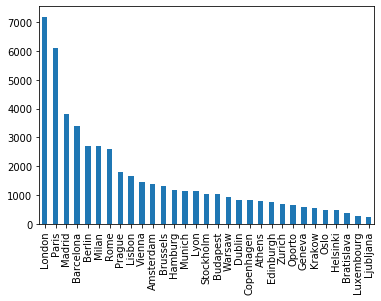

In [109]:
# Видим, что города сильно отличаются по своей представленности в датасете
Cities.plot(kind = 'bar')

In [110]:
# Можно предположить, что относительное количество ресторанов из разных городов 
# отражает и различия в численности населения городов. Этот признак надо сохранить. 
city_count_in_data = Cities.to_dict()
data['City Count in Data'] = data['City'].apply(lambda x: city_count_in_data.get(x))

In [111]:
# Создадим словарь, в котором укажем данные о численности населения и количестве ресторанов в городе

city_info = {
    'London': [8787892, 16973], 
    'Paris': [2140526, 15432],
    'Madrid': [3223334, 10019],
    'Barcelona': [1620343, 8608],
    'Berlin': [3601131, 5933],
    'Milan': [1366180,  6672],
    'Rome': [2872800, 10109],
    'Prague': [1280508, 4619],
    'Lisbon': [505526, 4452],
    'Vienna': [1840573, 3744],
    'Amsterdam': [859732, 3651],
    'Brussels': [1198726, 2365],
    'Hamburg': [1830584, 2881],
    'Munich': [1456039, 2838],
    'Lyon': [515695, 2512],
    'Stockholm': [961609, 2709],
    'Budapest': [1749734, 2751],
    'Warsaw': [1758143, 2733],
    'Dublin': [553165, 2070],
    'Copenhagen': [615993, 1955],
    'Athens': [655780, 2300],
    'Edinburgh': [537000, 1727],
    'Zurich': [402275, 1659],
    'Oporto': [249633, 1822],
    'Geneva': [499480, 1369],
    'Krakow': [779115, 1492],
    'Oslo': [673469, 1146],
    'Helsinki': [643272, 1384],
    'Bratislava': [424428, 1037],
    'Luxembourg': [122273, 659],
    'Ljubljana': [279631, 540]
}

In [112]:
# Численность населения
data['City Population'] = data['City'].apply(lambda x: city_info.get(x)[0])

In [113]:
# Количество ресторанов в городе
data['Restaurant Count in City'] = data['City'].apply(lambda x: city_info.get(x)[1])

In [114]:
# Посчитаем индекс - количество людей, которое приходится на один ресторан
data['Persons per Restaurant City Index'] = data['City Population']/data['Restaurant Count in City']

### 3. Cuisine Style
Номинальная переменная. Представлена списками. 11590 пропущенных значений. 


In [115]:
# Создадим отдельный столбец, в котором зафиксируем, что значение пропущено
data['Missing Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('uint8') 

# заполним пропуски значением 'Missing'
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Missing']")


In [116]:
# Вытащим в отдельный столбец типы кухонь в виде списка
data['Cuisine Style List'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")

In [117]:
data['Cuisine Style List'].head()

0                                           [Bar, Pub]
1    [European, Scandinavian, Gluten Free Options, ...
2                                [Vegetarian Friendly]
3    [Italian, Mediterranean, European, Vegetarian ...
4    [Italian, Mediterranean, European, Seafood, Ve...
Name: Cuisine Style List, dtype: object

In [118]:
# Посчитаем количество уникальных типов кухонь
c = Counter()
for line in data['Cuisine Style List']:
    for cuisine_style in line:
        c[cuisine_style] += 1
cuisine_styles = pd.Series(c)
cuisine_styles.sort_values(ascending=False)

Vegetarian Friendly    14021
European               12561
Missing                11590
Mediterranean           7820
Italian                 7433
                       ...  
Polynesian                 2
Salvadoran                 1
Xinjiang                   1
Burmese                    1
Latvian                    1
Length: 126, dtype: int64

In [119]:
# Новый столбец - богатство выбора в ресторане (сколько типов кухонь и диетических предпочтений они предлагают)
data['Cuisine Style Options'] = data['Cuisine Style List'].apply(lambda x: len(x))

In [120]:
# Специализированное меню ресторанов (такая характеристика есть на сайте)
special_diets = ['Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options', 'Kosher', 'Halal']

In [121]:
def get_special_diets(line):
    """ Функция для подсчета опций специализированного меню """
    
    counter = 0
    for item in line:
        if item in special_diets:
            counter +=1
    return counter

In [122]:
# Колонка "специализированное меню"
data['Special Diets'] = data['Cuisine Style List'].apply(get_special_diets)

In [123]:
data['Special Diets Binary'] = data['Special Diets'].apply(lambda x: 1 if x>0 else 0)

### 4. Ranking
Переменная в ранговой шкале. Пропусков нет. 

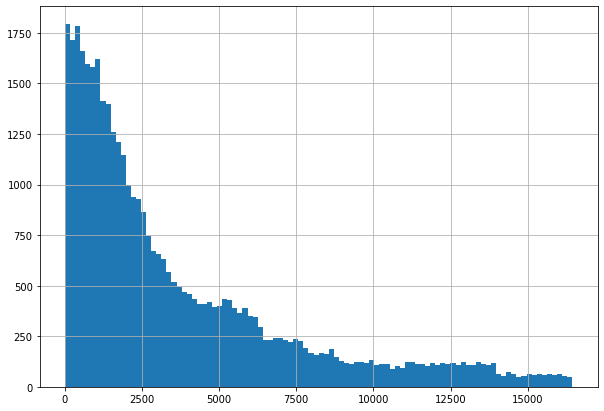

In [124]:
# Посмотрим на распределение признака
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

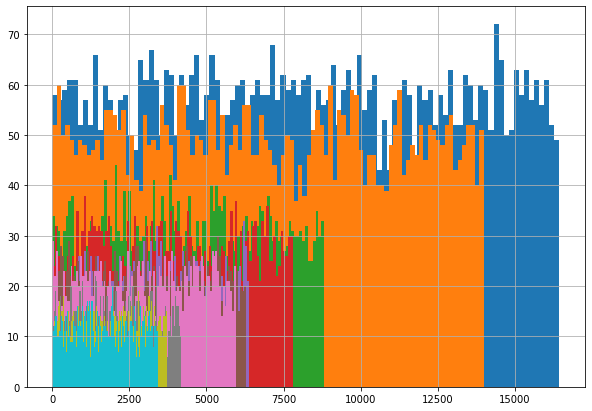

In [125]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

In [126]:
# относительный ранг ресторана
data['Relative Ranking'] = data['Ranking']/data['Restaurant Count in City']

In [127]:
data['Num of Visitors Estimate'] = data['Relative Ranking']*data['Persons per Restaurant City Index']

### 5. Price Range
Номинальная переменная. 17361 пропуск.

In [128]:
# сохраним информацию о пропусках чтобы не потерять
data['Missing Price Range'] = pd.isna(data['Price Range']).astype('uint8') 

In [129]:
# Наибольшее количество ресторанов находятся в среднем ценовом сегменте
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [130]:
data.groupby('Price Range')['Relative Ranking', 'Number of Reviews'].describe()

Relative Ranking                                          \
                       count      mean       std       min       25%   
Price Range                                                            
$                     7816.0  0.428793  0.252293  0.000225  0.229325   
$$ - $$$             23041.0  0.356281  0.261524  0.000059  0.142255   
$$$$                  1782.0  0.221543  0.238742  0.000100  0.047042   

                                          Number of Reviews              \
                  50%       75%       max             count        mean   
Price Range                                                               
$            0.396436  0.616876  1.245243            7603.0   92.887807   
$$ - $$$     0.295888  0.526519  1.266808           22762.0  187.251999   
$$$$         0.126617  0.314956  1.225793            1744.0  374.129014   

                                                           
                    std  min   25%    50%     75%     max  
Price Range                                                
$            231.580558  2.0  15.0   33.0   81.00  6360.0  
$$ - $$$     336.422557  2.0  32.0   82.0  205.00  8927.0  
$$$$         608.907745  2.0  53.0  174.5  465.25  9660.0

In [131]:
data.groupby('Missing Price Range')['Relative Ranking', 'Number of Reviews'].describe()

Relative Ranking                                          \
                               count      mean       std       min       25%   
Missing Price Range                                                            
0                            32639.0  0.366289  0.262266  0.000059  0.148839   
1                            17361.0  0.633206  0.198795  0.001743  0.494111   

                                                  Number of Reviews  \
                          50%       75%       max             count   
Missing Price Range                                                   
0                    0.312950  0.546095  1.266808           32109.0   
1                    0.638349  0.783067  1.271036           14691.0   

                                                                             
                           mean         std  min   25%   50%    75%     max  
Missing Price Range                                                          
0                    175.057990  341.926575  2.0  26.0  68.0  183.0  9660.0  
1                     13.907494   47.138990  2.0   4.0   7.0   14.0  3426.0

Данные по рангам и количеству отзывов позволяют заподозрить, что пропущенные значения могут быть из низкого ценового сегмента.

In [132]:
# Заполним пропуски модой
data['Price Range'] = data['Price Range'].fillna('$')

In [133]:
# заполним значения в переменной по словарю
price_to_num = {'$':1,'$$ - $$$':2,'$$$$':3}
data['Price Range Num'] = data['Price Range'].apply(lambda x: price_to_num.get(x))

### 6.Number of Reviews	
3200 пропусков. Количественная переменная.

In [134]:
# сохраним информацию о пропусках
data['Missing Number of Reviews'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [135]:
# Чаще всего отзывов два (мода)
data['Number of Reviews'].value_counts()

2.0       2403
3.0       2042
4.0       1707
5.0       1471
6.0       1258
          ... 
5216.0       1
1932.0       1
1050.0       1
1145.0       1
1471.0       1
Name: Number of Reviews, Length: 1573, dtype: int64

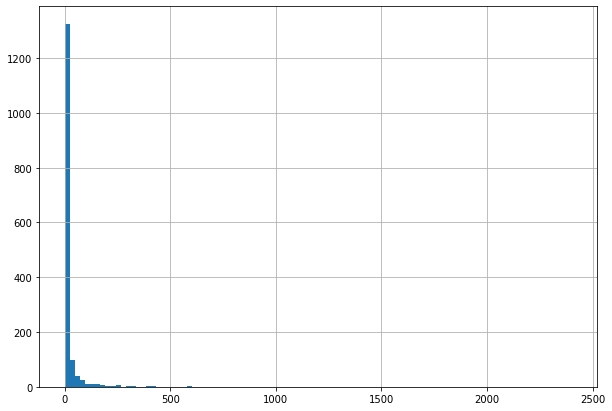

In [136]:
data['Number of Reviews'].value_counts().hist(bins=100)

In [137]:
data['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

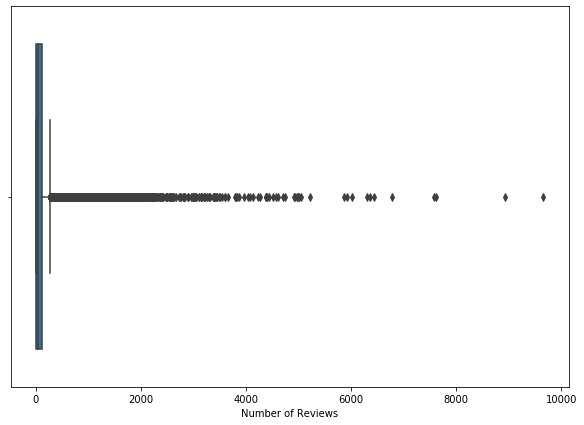

In [138]:
sns.boxplot(data['Number of Reviews'])

С точки зрения статистики, в количестве отзывов есть выбросы. Сложно их содержательно оценить, м.б. это действительно рестораны очень высокого уровня и у них резкий отрыв в количестве довольных посетителей. 

Можно попробовать заполнить средним в зависимости от ранга ресторана и уровня цен

In [139]:
# Картина характерная для низкого ценового уровня
data.groupby('Missing Number of Reviews')['Price Range Num','Relative Ranking'].median()

,Price Range Num,Relative Ranking
Missing Number of Reviews,,
0,2,0.424675
1,1,0.669119


In [140]:
data.groupby('Missing Number of Reviews')['Price Range Num','Relative Ranking'].mean()

,Price Range Num,Relative Ranking
Missing Number of Reviews,,
0,1.560897,0.444163
1,1.110937,0.675499


In [141]:
# Заполним пропуски медианой для низкого ценового уровня
data[data['Price Range Num'] == 1]['Number of Reviews'].median()

11.0

In [142]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(11)

### 7. Reviews
2 пропуска и 8112 пустых значений. Содержит тексты двух последних отзывов и даты этих отзывов. Формат данных - строка

In [143]:
# Количество пропусков
data.Reviews.isna().sum()

2

In [144]:
# Количество строчек с незаполненными данными - то есть, это тоже пропуски
len(data[data.Reviews == '[[], []]'])

8112

In [145]:
# Заполним два пропуска другим типом пустого значения, чтобы пустые значения выглядели одинаково
data.Reviews = data.Reviews.fillna('[[], []]')

In [146]:
# Зафиксируем информацию об отсутствии текста отзыва в отдельной колонке
data['Missing Reviews'] = data['Reviews'].apply(lambda x: 1 if x == '[[], []]' else 0)

> Извлекаем информацию о времени

In [147]:
# вытаскиваем в отдельную колонку даты. Пока что это список и строковый формат данных. 
data['Review Date'] = data['Reviews'].str.findall(r'\d+/\d+/\d+').to_list()

In [148]:
# Проверим, во всех ли строчках содержится по два значения даты. Для этого сделаем вспомогательный столбец
data['Num of Dates'] = data['Review Date'].apply(lambda x: len(x))

In [149]:
# Есть ситуация, когда три или одна дата
data['Num of Dates'].value_counts()

2    36202
0     8114
1     5680
3        4
Name: Num of Dates, dtype: int64

In [150]:
# Посмотрим на отзывы с тремя датами
data[data['Num of Dates'] == 3][['Review Date','Reviews']]

,Review Date,Reviews
2221,"[21/10/17, 12/22/2017, 10/19/2017]","[['We visited 21/10/17', 'Best Kebab in London..."
3809,"[30/5/2017, 04/13/2017, 05/30/2017]","[['Good Museum Cafeteria', 'Lunch 30/5/2017'],..."
19254,"[3/1/2017, 06/02/2017, 01/03/2017]","[['The desserts arcade !', 'Visit today 3/1/20..."
33348,"[29/9/2016, 09/30/2016, 08/25/2016]","[['lunch 29/9/2016', 'Unplanned Great Dinner']..."


Попали даты из текстов отзывов. Причем даты из отзывов написаны в формате день-месяц-год. Рестораны европейские, 
мб и посетители европейцы. А сам сайт американский, так что внутри даты в другом формате - месяц-день-год.

In [151]:
# Создаем отдельный признак с датами формата datetime
data['Review Date DT'] = data['Review Date'].apply(lambda x: pd.to_datetime(x))

In [152]:
# Каким-то чудесным образом компьютер все правильно обработал
data[data['Num of Dates'] == 3]['Review Date DT']

2221     DatetimeIndex(['2017-10-21', '2017-12-22', '20...
3809     DatetimeIndex(['2017-05-30', '2017-04-13', '20...
19254    DatetimeIndex(['2017-03-01', '2017-06-02', '20...
33348    DatetimeIndex(['2016-09-29', '2016-09-30', '20...
Name: Review Date DT, dtype: object

In [153]:
data['Review Date DT'].loc[3809]

DatetimeIndex(['2017-05-30', '2017-04-13', '2017-05-30'], dtype='datetime64[ns]', freq=None)

In [154]:
# там, где ситуация неочевидная, он все-таки перепутал
data['Review Date DT'].loc[19254]

DatetimeIndex(['2017-03-01', '2017-06-02', '2017-01-03'], dtype='datetime64[ns]', freq=None)

In [155]:
# Заморачиваться не буду, исправлю вручную. Поскольку дата дублируется, просто уберу ее
data['Review Date'].loc[19254] = data['Review Date'].loc[19254][1:]

In [156]:
# Задаем текущую дату
current_date = pd.datetime.now()

In [157]:
# Посмотрим на ситуацию, когда только одна дата отзыва
data[data['Num of Dates'] == 1]['Missing Number of Reviews'].value_counts()

0    4504
1    1176
Name: Missing Number of Reviews, dtype: int64

In [158]:
# Создадим колонки с датой первого и последнего отзыва
# Если дата одна, будем считать, что это дата и первого, и последнего отзыва
data['First Review Date'] = data['Review Date DT'].apply(lambda x: x.min())
data['Last Review Date'] = data['Review Date DT'].apply(lambda x: x.max())

In [159]:
# Создадим числовые колонки на основе признаков со временем
# Количество дней после последнего и первого отзыва, временной промежуток между отзывами в днях
data['Days from Last Review'] = (current_date - data['Last Review Date']).dt.days 
data['Days from First Review'] = (current_date - data['First Review Date']).dt.days
data['Days between Reviews'] = (data['Last Review Date'] - data['First Review Date']).dt.days

In [160]:
data['Days from Last Review'].describe()

count    41886.000000
mean      1277.045361
std        363.252094
min        987.000000
25%       1066.000000
50%       1140.000000
75%       1324.000000
max       6046.000000
Name: Days from Last Review, dtype: float64

In [161]:
data['Days between Reviews'].describe()

count    41886.000000
mean       123.218331
std        212.592518
min          0.000000
25%          8.000000
50%         49.000000
75%        148.000000
max       3296.000000
Name: Days between Reviews, dtype: float64

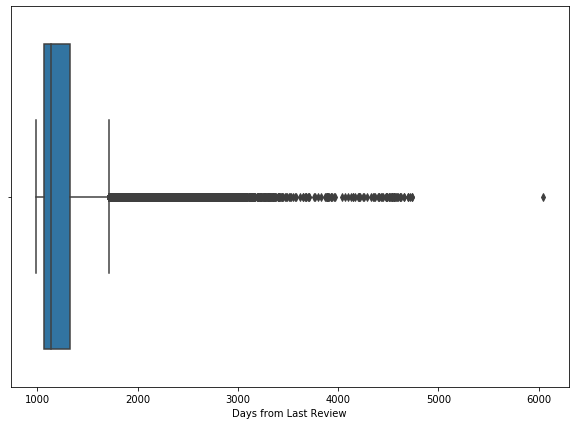

In [162]:
sns.boxplot(data['Days from Last Review'])

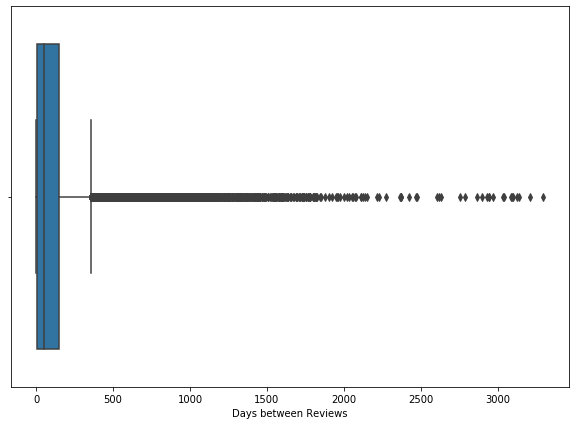

In [163]:
sns.boxplot(data['Days between Reviews'])

In [164]:
# Пропуски заполним нулем
data['Days from Last Review'] = data['Days from Last Review'].fillna(0)


In [165]:
data['Days from First Review'] = data['Days from First Review'].fillna(0)


In [166]:
# Наверное, для удобства сразу надо делать именно такой расчет
data['Days between Reviews'] = data['Days from Last Review'] - data['Days from First Review']

In [167]:
# Удалим ненужные переменные
data.drop(['Review Date', 'Review Date DT', 'First Review Date', 'Last Review Date', 'Num of Dates'], axis = 1, inplace=True)

In [168]:
data.drop(['Reviews'], axis = 1, inplace=True)

### 8. URL_TA
Ссылка на страницу ресторана на 'www.tripadvisor.com'


In [169]:
# Посмотрим, как выглядят данные
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Можно вытащить название региона, города и ресторана, идентификатор ресторана. У нас уже есть несколько колонок с этой информацией. 
Этот столбец может понадобиться, если надо будет собрать дополнительную информацию с сайта Tripadvisor. Пока что я предлагаю этот столбец удалить. 

In [170]:
data.drop(['URL_TA'], axis = 1, inplace=True)

### 9. ID_TA
Идентификатор ресторана на сайте Tripadvisor. Никакой дополнительной информации не несет. Можно смело удалять. 

In [171]:
data.drop(['ID_TA'], axis = 1, inplace=True)

## Матрица корреляций

(20.0, 0.0)

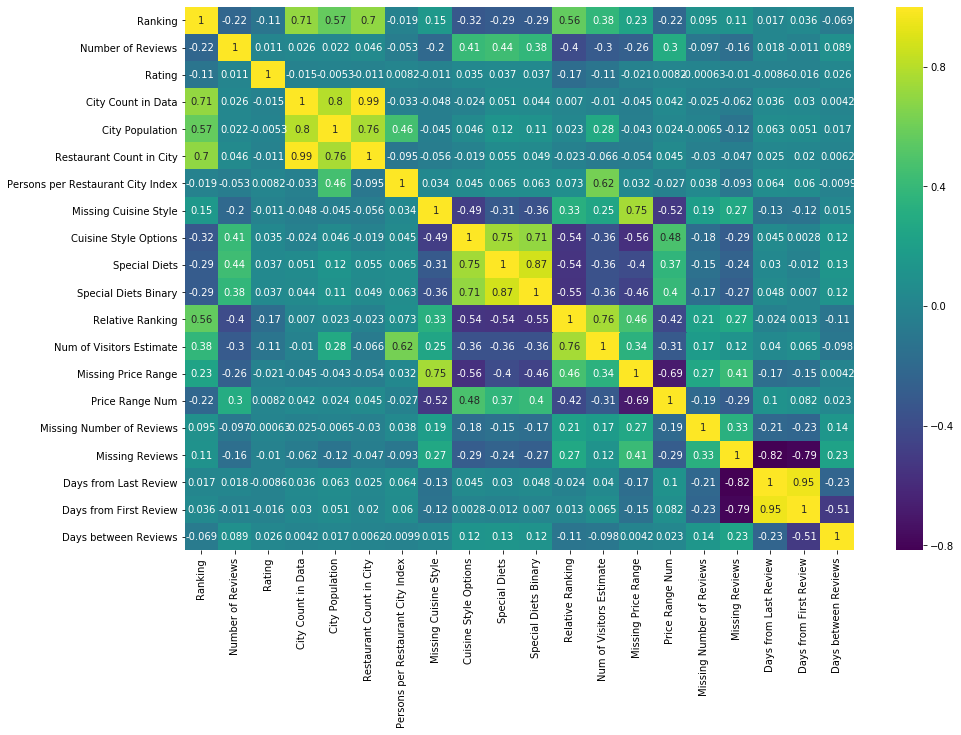

In [172]:
plt.rcParams['figure.figsize'] = (15,10)
ax = sns.heatmap(data.drop(['sample'], axis=1).corr(), annot = True, cmap = 'viridis')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [173]:
# Удалим переменные с высокой корреляцией
#data.drop(['Days from First Review', 'City Count in Data', 'Missing Cuisine Style'], axis = 1, inplace=True)

# Дополнительная обработка данных

In [174]:
# Создадим dummy-переменные 
data = pd.get_dummies(data, columns=['City'], dummy_na=True)
#data.drop(['City'], axis = 1, inplace=True)

In [175]:
#Создаем dummy-переменные для типов кухонь
cuisine_style_dummy = data['Cuisine Style List'].apply(lambda x: pd.Series([1] * len(x), index=x)).fillna(0, downcast='infer')

data = pd.merge(data, cuisine_style_dummy, left_index=True, right_index=True, how='left')

In [176]:
# удаляем номинальные признаки
data.drop(['Cuisine Style','Cuisine Style List',], axis = 1, inplace=True)

In [177]:
# Удалим данные по цене в номинальной шкале
data.drop(['Price Range'], axis = 1, inplace=True)

In [178]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 179 entries, Ranking to Latvian
dtypes: float64(9), int64(135), uint8(35)
memory usage: 56.6 MB


In [179]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [180]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [181]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 178), (40000, 178), (40000, 177), (32000, 177), (8000, 177))

# Построение модели
Сам ML

In [182]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [183]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [184]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [185]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20170687499999998


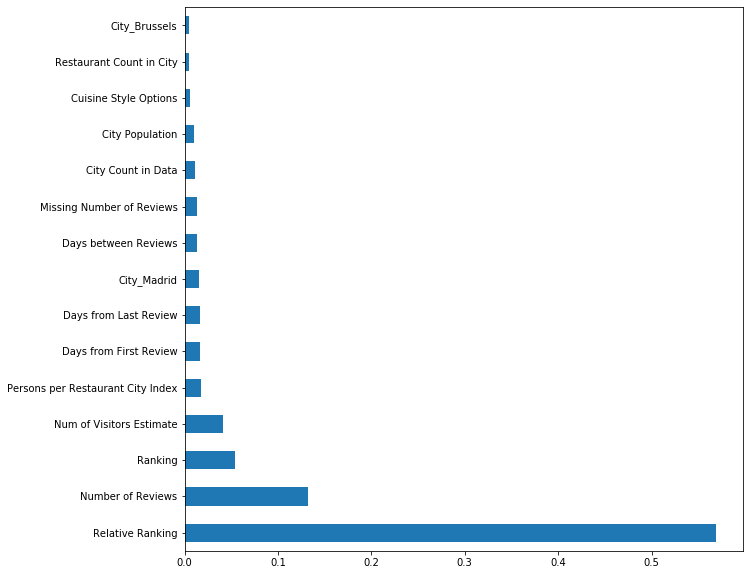

In [186]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Готовим Submission на кагл

In [187]:
test_data.sample(10)

,Ranking,Number of Reviews,Rating,City Count in Data,City Population,Restaurant Count in City,Persons per Restaurant City Index,Missing Cuisine Style,Cuisine Style Options,Special Diets,...,Albanian,Central Asian,Polynesian,Caucasian,Uzbek,Salvadoran,Xinjiang,Burmese,Fujian,Latvian
5989,6235.0,6.0,0.0,3813,3223334,10019,321.722128,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5952,10477.0,3.0,0.0,7193,8787892,16973,517.757144,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5593,7644.0,42.0,0.0,3813,3223334,10019,321.722128,1,1,0,...,0,0,0,0,0,0,0,0,0,0
5411,1613.0,79.0,0.0,6108,2140526,15432,138.706973,0,4,0,...,0,0,0,0,0,0,0,0,0,0
3802,4062.0,32.0,0.0,2589,2872800,10109,284.182412,0,4,1,...,0,0,0,0,0,0,0,0,0,0
3409,599.0,94.0,0.0,1647,505526,4452,113.550314,0,4,2,...,0,0,0,0,0,0,0,0,0,0
2660,1863.0,11.0,0.0,1443,1840573,3744,491.606036,0,2,0,...,0,0,0,0,0,0,0,0,0,0
8412,2944.0,11.0,0.0,1647,505526,4452,113.550314,1,1,0,...,0,0,0,0,0,0,0,0,0,0
733,1136.0,95.0,0.0,1372,859732,3651,235.478499,0,8,3,...,0,0,0,0,0,0,0,0,0,0
9516,2712.0,11.0,0.0,1186,1830584,2881,635.398820,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
test_data = test_data.drop(['Rating'], axis=1)

In [189]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [190]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


In [191]:
predict_submission

array([3.085, 4.19 , 4.385, ..., 3.035, 4.445, 4.425])

In [192]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.085
1,id_1,4.190
2,id_2,4.385
3,id_3,4.355
4,id_4,4.480
5,id_5,4.425
6,id_6,1.495
7,id_7,2.875
8,id_8,4.075
9,id_9,4.695
